## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating data providers and ARIA specific pre-processing
the providers are stored in the **providers** dictionary and have the name format {"provider"_imagename }

In [2]:
#creating dataproviders for the images in the controlled datset
!pip install -q projectaria-tools
from projectaria_tools.core import data_provider
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId

def CreateDataProvider( filepath ):
  provider = data_provider.create_vrs_data_provider(filepath)
  assert provider is not None, "cannot open file"
  return provider

providers = {
    "provider_natural_lighting_1m_2880": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_lighting_1m_2880.vrs"),
    "provider_natural_lighting_1m_1408": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_lighting_1m_1408.vrs"),
    "provider_natural_lighting_50cm_2880": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_lighting_50cm_2880.vrs"),
    "provider_natural_lighting_50cm_1408": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_lighting_50cm_1408.vrs"),
    "provider_natural_and_artificial_lighting_1m_2880": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_and_artificial_lighting_1m_2880.vrs"),
    "provider_natural_and_artificial_lighting_1m_1408": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_and_artificial_lighting_1m_1408.vrs"),
    "provider_natural_and_artificial_lighting_50cm_2880": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_and_artificial_lighting_50cm_2880.vrs"),
    "provider_natural_and_artificial_lighting_50cm_1408": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_and_artificial_lighting_50cm_1408.vrs"),
    "provider_nightime_lighting_besdide_lamp_1m_2880": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Nighttime_lighting_bedside_lamp_1m_2880.vrs"),
    "provider_nightime_lighting_besdide_lamp_1m_1408": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Nighttime_lighting_bedside_lamp_1m_1408.vrs"),
    "provider_nightime_lighting_besdide_lamp_50cm_2880": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Nighttime_lighting_bedside_lamp_50cm_2880.vrs"),
    "provider_nightime_lighting_besdide_lamp_50cm_1408": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Nighttime_lighting_bedside_lamp_50cm_1408.vrs"),
    "provider_natural_and_enhanced_lighting_1m_2880": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_and_enhanced_artificial_lighting_1m_2880.vrs"),
    "provider_natural_and_enhanced_lighting_1m_1408": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_and_enhanced_artificial_lighting_1m_1408.vrs"),
    "provider_natural_and_enhanced_lighting_50cm_2880": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_and_enhanced_artificial_lighting_50cm_2880.vrs"),
    "provider_natural_and_enhanced_lighting_50cm_1408": CreateDataProvider("/content/drive/MyDrive/Aria_glasses/Recordings/lighting_and_distance_exploration/Natural_and_enhanced_artificial_lighting_50cm_1408.vrs")
}

#checking if we have the right data for the right image
# for provider_name, provider in providers.items():
#     print(f"{provider_name} has image data:")
#     config = provider.get_image_configuration(provider.get_stream_id_from_label("camera-rgb"))
#     print( f"image resolution {config.image_width}x{config.image_height}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 11.5 MB/s eta 0:00:00


### Aria specific Image Pre-processing
for openCv to utilize the images they have to be in BGR color wave
images gained from the provider for some reason are rotaed 90 degrees
the un-rotated images are stored in the **images** dictionary


In [3]:
#getting images from frame number 1
stream_lablel = "camera-rgb"

def get_image_from_frame(provider, frame_number):
  stream_id = provider.get_stream_id_from_label(stream_lablel)
  image = provider.get_image_data_by_index(stream_id, 1)
  image_array = image[0].to_numpy_array()
  return image_array

images = {}

for provider_name, provider in providers.items():
  images[provider_name.replace("provider_","")] = get_image_from_frame(provider, 1)

In [4]:
#applying aria specific pre_processing
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def pre_process_image(image_array):
  image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
  image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
  return image

for imageName, image in images.items():
  images[imageName] = pre_process_image(image)

## Base Algorithm Accuracy Test

### Algorithm and fucntiocnality fucntions

In [5]:
import numpy as np

def merge_bounding_boxes(boxes, epsilon_y=10, alpha=2.0):
    boxes = sorted(boxes, key=lambda x: (x[1], x[0]))

    merged_boxes = []
    current_group = [boxes[0]]

    def merge_group(group):
        x1 = min(b[0] for b in group)
        y1 = min(b[1] for b in group)
        x2 = max(b[2] for b in group)
        y2 = max(b[3] for b in group)
        return (x1, y1, x2, y2)

    for box in boxes[1:]:
        startX2, startY2, endX2, endY2 = box
        _, startY1, _, endY1 = current_group[-1]

        # Check if Y is within epsilon
        if abs(startY1 - startY2) <= epsilon_y or abs(endY1 - endY2) <= epsilon_y:

            # Calculate average width of current group
            avg_width = np.mean([b[2] - b[0] for b in current_group])

            # Check if X separation is too large (indicating a new column)
            last_endX = current_group[-1][2]
            if (startX2 - last_endX) > alpha * avg_width:
                # Merge current group and start a new one
                merged_boxes.append(merge_group(current_group))
                current_group = [box]
            else:
                current_group.append(box)
        else:
            # Merge current group and start a new one for different lines
            merged_boxes.append(merge_group(current_group))
            current_group = [box]

    # Final merge
    if current_group:
        merged_boxes.append(merge_group(current_group))

    return merged_boxes

In [6]:
!sudo apt install tesseract-ocr
!pip install pytesseract -q
!pip install easyocr -q

import pytesseract
import easyocr

def apply_pyTesseract_to_text_box(text_region):
  recognized_text = pytesseract.image_to_string(text_region)
  return recognized_text

def apply_crnn_to_text_box(text_region):
  reader = easyocr.Reader(['en'])
  result = reader.readtext(text_region)
  recognized_text = result[0][1] if result else ""
  return recognized_text

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.

In [7]:
import cv2
import time
import numpy as np
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow

def apply_east_with_recognition_algorithm( image, recognition_algorithm,
                                          general_pre_processing = None, TexBox_specific_pre_processing = None ):
    # Load the image
    orig = image.copy()
    (H, W) = image.shape[:2]

    # Calculate new dimensions divisible by 32
    newW = (W // 32) * 32
    newH = (H // 32) * 32

    # Save the aspect ratio
    rW = W / float(newW)
    rH = H / float(newH)

    #resize the image with the new W and H
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    #apply whole image pre processing
    if general_pre_processing:
      image = general_pre_processing(image)

    # Load EAST text detector
    net = cv2.dnn.readNet("/content/drive/MyDrive/Aria_glasses/Algorithms/frozen_east_text_detection.pb")
    layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

    # Convert the image to a blob and perform forward pass
    blob = cv2.dnn.blobFromImage(image, 1, (W, H),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    print(f"[INFO] Text detection took {end - start:.6f} seconds")

    # Process the EAST output
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos, sin = np.cos(angle), np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    mergedBoxes = merge_bounding_boxes(boxes)
    full_text = ""

    for box in mergedBoxes:
        startX, startY, endX, endY = box

        # Extract the text region from the original image
        text_region = orig[startY:endY, startX:endX]

        #apply text box pre processing
        if TexBox_specific_pre_processing:
          new_image = TexBox_specific_pre_processing(orig)
          text_region = new_image[startY:endY, startX:endX]

        # Convert to grayscale for OCR
        gray_text_region = cv2.cvtColor(text_region, cv2.COLOR_BGR2GRAY)

        recognized_text = recognition_algorithm(gray_text_region)

        # Extract the recognized text
        full_text += recognized_text + " "

        # Draw the bounding box and recognized text on the original image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        cv2.putText(orig, recognized_text, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2_imshow(orig)

    return full_text

In [8]:
def calculate_error_rate(ground_truth, predicted):

  S = 0  # Substitutions
  D = 0  # Deletions
  I = 0  # Insertions

  # Calculate errors using Levenshtein distance
  n = len(ground_truth)
  m = len(predicted)
  dp = [[0 for _ in range(m + 1)] for _ in range(n + 1)]

  for i in range(n + 1):
    for j in range(m + 1):
      if i == 0:
        dp[i][j] = j
      elif j == 0:
        dp[i][j] = i
      elif ground_truth[i - 1] == predicted[j - 1]:
        dp[i][j] = dp[i - 1][j - 1]
      else:
        dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

  S = dp[n][m]

  # Calculate individual error types (S, D, I)
  i = n
  j = m
  while i > 0 and j > 0:
    if ground_truth[i - 1] == predicted[j - 1]:
      i -= 1
      j -= 1
    else:
      if dp[i][j] == dp[i - 1][j - 1] + 1:  # Substitution
        S += 1
        i -= 1
        j -= 1
      elif dp[i][j] == dp[i - 1][j] + 1:  # Deletion
        D += 1
        i -= 1
      elif dp[i][j] == dp[i][j - 1] + 1:  # Insertion
        I += 1
        j -= 1

  while i > 0:  # Remaining deletions
    D += 1
    i -= 1

  while j > 0:  # Remaining insertions
    I += 1
    j -= 1


  # Calculate error recognition rate (ER)
  N = len(ground_truth)  # Total number of characters in ground truth
  ER = (S + D + I) / N

  return ER

In [9]:
def format_found_text(text):
  text = text.replace('\n', ' ')
  if text.strip() == '':
    text = ''

  text = text.replace('  ', ' ')
  return text


In [10]:
#this function will take in, ground truth data, a text pred function and a dictionary of images/image names and return a dictionary
#with image name and error rate
def get_image_dic_error_rate_for_algorithm(
    ground_truth, text_pred_func, image_dictionary,
    text_format_func, text_rec_algo,
    general_pre_processing = None, TexBox_specific_pre_processing = None
    ):
  error_rates_per_image = {}
  recongized_text_per_image= {}
  for imageName, image in image_dictionary.items():
    print(f"PROCESSING -> image: {imageName}")
    recognized_text = text_format_func(text_pred_func(image, text_rec_algo, general_pre_processing, TexBox_specific_pre_processing))
    recongized_text_per_image[imageName] = recognized_text
    print(f"RECOGNIZED TEXT -> recognized text: {recognized_text}\n")
    error_rates_per_image[imageName] = calculate_error_rate(ground_truth, recognized_text)
  return error_rates_per_image, recongized_text_per_image


In [11]:
import matplotlib.pyplot as plt
import numpy as np


def display_image_error_rates_for_every_image(error_rates_1, error_rates_2, plot_title, algo_name_1, algo_name_2 ):
# Get image names and error rates for both dictionaries
  image_names = list(error_rates_1.keys())
  error_rates_crnn = list(error_rates_1.values())
  error_rates_pytesseract = list(error_rates_2.values())

  # Create bar positions
  bar_width = 0.35
  x_pos = np.arange(len(image_names))

  # Create bar plot
  fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size as needed
  rects1 = ax.bar(x_pos - bar_width/2, error_rates_crnn, bar_width, label=algo_name_1)
  rects2 = ax.bar(x_pos + bar_width/2, error_rates_pytesseract, bar_width, label=algo_name_2)

  # Add labels, title, and legend
  ax.set_ylabel('Error Rate')
  ax.set_title( plot_title )
  ax.set_xticks(x_pos)
  ax.set_xticklabels(image_names, rotation=45, ha='right')  # Rotate x-axis labels for better readability
  ax.legend()

  # Add error rate values on top of bars (optional)
  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{:.2f}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

  autolabel(rects1)
  autolabel(rects2)

  # Display the plot
  plt.tight_layout()
  plt.show()

In [12]:
def calculate_average_error_rate(error_rates_dictionary):
  error_rates = list(error_rates_dictionary.values())
  average_error_rate = sum(error_rates) / len(error_rates) if error_rates else 0  # Avoid division by zero
  return average_error_rate


### Calulating the error rates per image per algorithm

In [13]:
ground_truth_text = "Hello world! This is Joseph testing the meta glasses"

east_with_crnn_error_rates, east_with_crnn_recognzied_texts = get_image_dic_error_rate_for_algorithm(
                                                              ground_truth_text, apply_east_with_recognition_algorithm,
                                                              images, format_found_text, apply_crnn_to_text_box )

east_with_pyTesseract_error_rates, east_with_pyTesseract_recognzied_texts= get_image_dic_error_rate_for_algorithm(
                                                              ground_truth_text, apply_east_with_recognition_algorithm,
                                                              images, format_found_text, apply_pyTesseract_to_text_box )


Output hidden; open in https://colab.research.google.com to view.

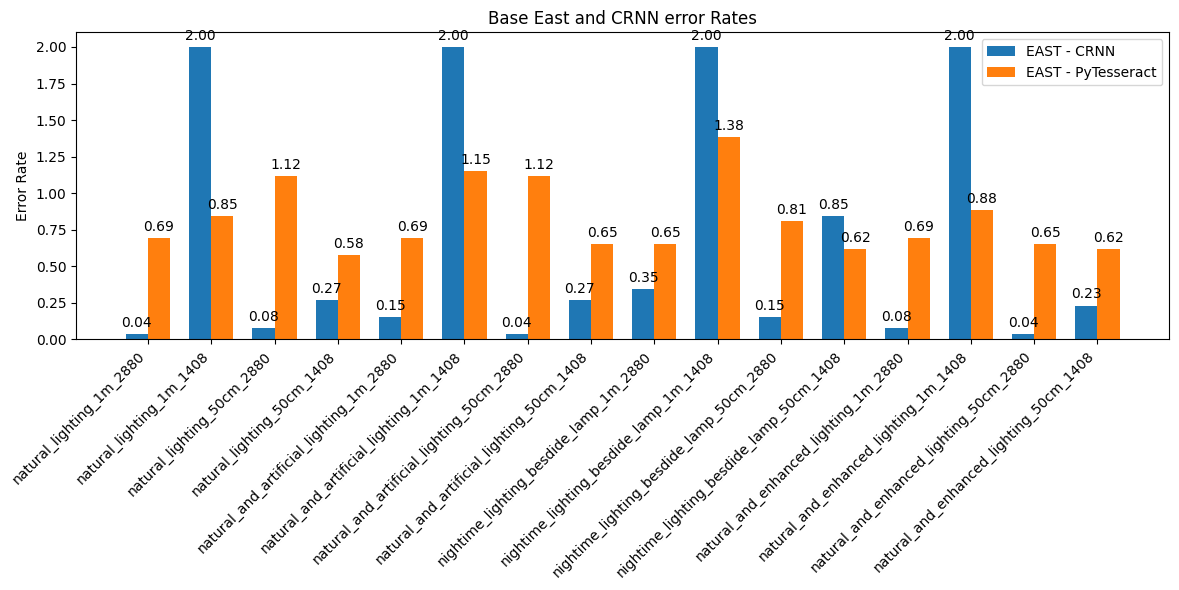

The average error rate for EAST with PyTesseract is: 0.8221153846153846
The average error rate for EAST with CRNN is: 0.658653846153846


In [14]:
display_image_error_rates_for_every_image(
                                            east_with_crnn_error_rates, east_with_pyTesseract_error_rates,
                                            "Base East and CRNN error Rates",
                                            "EAST - CRNN",
                                            "EAST - PyTesseract" )

print( f"The average error rate for EAST with PyTesseract is: {calculate_average_error_rate(east_with_pyTesseract_error_rates)}")
print( f"The average error rate for EAST with CRNN is: {calculate_average_error_rate(east_with_crnn_error_rates)}")

### Analysis of gathered data
East with Pytesseract seems to perform worse on average with a an average error rate of:
East with CRNN seems to perform better on average, however something interesting happenes when looking at the graph.

#### CRNN fails to recognize any text in images of 1m distance with resolution of 1408
East with CRNN seems not to recognize any text any of the images that are at a distance of 1m and a resolution of 1408 no matter the lighting conditions.

#### This may be due to the granularity of the image. and other factors, this can be improved in the later stages of exploration.

## Lighting, Distance and Resolutions effects on character error rate

### Immage upscaling -> all the images for CRNN that performed worse have a resolution of 1408 x 1408, upscaling them to double that resolution to view performance.

In [15]:
def upscale_image(image):
  print(image.shape[0])
  if image.shape[0] == 1408 and image.shape[1] == 1408:
    # Get new dimensions (double the size)
    new_width = image.shape[1] * 2
    new_height = image.shape[0] * 2

    # Resize using INTER_CUBIC
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

  return image

#try upscaling all images
upscaled_images = {}
for imageName, image in images.items():
  upscaled_image = upscale_image(image)
  print(upscaled_image.shape)
  upscaled_images[imageName] = upscaled_image




2880
(2880, 2880, 3)
1408
(2816, 2816, 3)
2880
(2880, 2880, 3)
1408
(2816, 2816, 3)
2880
(2880, 2880, 3)
1408
(2816, 2816, 3)
2880
(2880, 2880, 3)
1408
(2816, 2816, 3)
2880
(2880, 2880, 3)
1408
(2816, 2816, 3)
2880
(2880, 2880, 3)
1408
(2816, 2816, 3)
2880
(2880, 2880, 3)
1408
(2816, 2816, 3)
2880
(2880, 2880, 3)
1408
(2816, 2816, 3)


In [16]:
ground_truth_text = "Hello world! This is Joseph testing the meta glasses"

x,y = get_image_dic_error_rate_for_algorithm(
                                             ground_truth_text, apply_east_with_recognition_algorithm,
                                              upscaled_images, format_found_text, apply_crnn_to_text_box )


for image_name, error_rate in x.items():
  print(f"Image: {image_name}, Error Rate: {error_rate}")

Output hidden; open in https://colab.research.google.com to view.

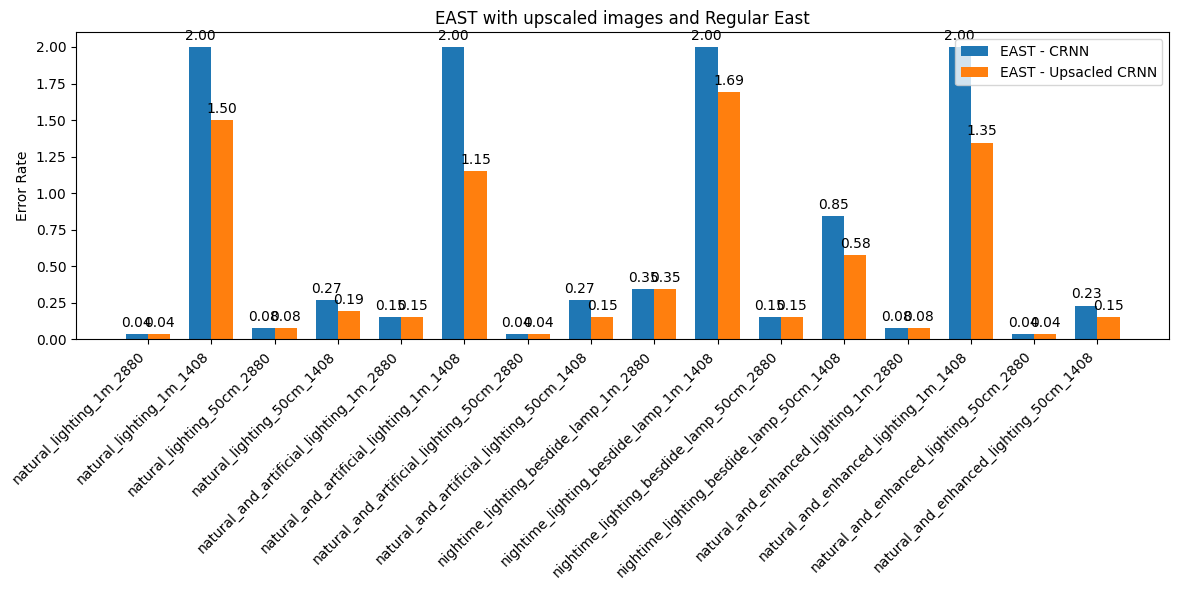

The average error rate for EAST with CRNN is: 0.658653846153846
The average error rate for EAST with enhanced CRNN is: 0.4807692307692308


In [17]:
display_image_error_rates_for_every_image(
                                            east_with_crnn_error_rates, x,
                                            "EAST with upscaled images and Regular East",
                                            "EAST - CRNN",
                                            "EAST - Upsacled CRNN" )

print( f"The average error rate for EAST with CRNN is: {calculate_average_error_rate(east_with_crnn_error_rates)}")
print( f"The average error rate for EAST with enhanced CRNN is: {calculate_average_error_rate(x)}")


#### General use functions for lighting Exploration

In [18]:
import cv2
import numpy as np

def calculate_mean_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray_image)

def calculate_std_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.std(gray_image)

def calculate_global_luminance(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return np.mean(hsv_image[:, :, 2])

def calculate_contrast(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image.max() - gray_image.min()

In [19]:
image_lighting_results = {}

for image_name, image in images.items():
  results = [
      calculate_mean_brightness(image),
      calculate_std_brightness(image),
      calculate_global_luminance(image),
      calculate_contrast(image),
  ]
  image_lighting_results[image_name] = results


In [20]:
import numpy as np

def get_average_lighting_from_results(image_lighting_results):
    brightness_values = [results[0] for results in image_lighting_results.values()]
    std_values = [results[1] for results in image_lighting_results.values()]
    luminance_values = [results[2] for results in image_lighting_results.values()]
    contrast_values = [results[3] for results in image_lighting_results.values()]

    average_results = {
        'mean_brightness': np.mean(brightness_values),
        'std_brightness': np.mean(std_values),
        'global_luminance': np.mean(luminance_values),
        'contrast': np.mean(contrast_values)
    }

    return average_results

average_lighting = get_average_lighting_from_results(image_lighting_results)
print(average_lighting)

{'mean_brightness': np.float64(58.67756134574991), 'std_brightness': np.float64(29.568811913412674), 'global_luminance': np.float64(77.728289346873), 'contrast': np.float64(148.0)}


In [21]:
def get_image_distance_and_resolution(image_name):
  parts = image_name.split('_')
  if len(parts) >= 3:
    try:
      distance_str = parts[2]
      if distance_str.endswith('cm'):
        distance = float(distance_str[:-2])
      elif distance_str.endswith('m'):
        distance = float(distance_str[:-1]) * 100
      else:
        return None

      resolution = int(parts[-1])
      return distance, resolution
    except ValueError:
      return None
  return None



In [22]:
import re

def get_image_distance_and_resolution(image_name):
  # Use a regular expression to match the pattern
  match = re.search(r"(\d+)(cm|m)_(\d+)$", image_name)

  if match:
    distance_str = match.group(1)
    distance_unit = match.group(2)
    resolution_str = match.group(3)

    try:
      distance = float(distance_str)
      if distance_unit == "m":
        distance *= 100  # Convert meters to centimeters
      resolution = int(resolution_str)
      return distance, resolution
    except ValueError:
      print(f"Warning: Error parsing distance or resolution in image name: {image_name}")
      return None, None
  else:
    print(f"Warning: Distance and resolution pattern not found in image name: {image_name}")
    return None, None

In [23]:
def shorten_image_name(image_name):
  words = image_name.split('_')  # Split into words
  initials = [word[0] for word in words]  # Get the first letter of each word
  shortened_name = "_".join(initials)  # Join the initials

  return shortened_name


In [24]:
import matplotlib.pyplot as plt

def show_lighting_plot(algorithm_error_rates, lighting_data, plot_name, lighting_type, ):
    error_rates_values = list(algorithm_error_rates.values())
    plt.rcParams['font.family'] = 'DejaVu Sans Mono'
    plt.figure(figsize=(10, 6))
    plt.scatter(lighting_data, error_rates_values, marker='o', s=80,
                c=error_rates_values, cmap='winter',
                edgecolors='k', linewidths=1)

    plt.xlabel("Mean Brightness", fontsize=12)
    plt.ylabel(f"Error Rate", fontsize=12)
    plt.title(f"{plot_name} Error Rate - {lighting_type}", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    for i, imageName in enumerate(algorithm_error_rates.keys()):
        distance, resolution = get_image_distance_and_resolution( imageName )
        text = f"{shorten_image_name( imageName)}_{distance}_{resolution}"
        plt.annotate( text, (lighting_data[i], algorithm_error_rates[imageName]), fontsize=7)

    plt.colorbar(label="Error Rate")
    plt.tight_layout()
    plt.show()

def show_plot_for_lighting_type(algorithm_error_rates, lighting_type, lighting_type_str, plot_name ):
  lighting_data = [results[lighting_type] for results in image_lighting_results.values()]
  show_lighting_plot(algorithm_error_rates, lighting_data, plot_name, lighting_type_str);


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_correlation_matrix_for_lighting_results( image_lighting_results, algorithm_error_rates, graph_title):
  data = []
  for image_name in image_lighting_results:
    data.append({
        'image_name': image_name,
        'mean_brightness': image_lighting_results[image_name][0],
        'std_brightness': image_lighting_results[image_name][1],
        'global_luminance': image_lighting_results[image_name][2],
        'contrast': image_lighting_results[image_name][3],
        'error_rate': algorithm_error_rates[image_name]
    })


  df = pd.DataFrame(data)


  correlation_matrix = df[['mean_brightness', 'std_brightness', 'global_luminance', 'contrast', 'error_rate']].corr()


  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='ocean', fmt=".2f")
  plt.title(f"Correlation Matrix, lightings effect on {graph_title} error rates")
  plt.show()


In [26]:
def create_correlation_matrix_for_distance_and_resolution_results( algorithm_error_rates, algorithm_name):
  # Create a list of dictionaries, each containing image name, distance, resolution, and error rate
  data_with_distance_resolution = []
  for image_name in algorithm_error_rates:
      distance_resolution = get_image_distance_and_resolution(image_name)
      if distance_resolution:
          distance, resolution = distance_resolution
          data_with_distance_resolution.append({
              'image_name': image_name,
              'distance': distance,
              'resolution': resolution,
              'error_rate': algorithm_error_rates[image_name]
          })

  # Create the Pandas DataFrame
  df_distance_resolution = pd.DataFrame(data_with_distance_resolution)

  # Calculate the correlation matrix
  correlation_matrix_distance_resolution = df_distance_resolution[['distance', 'resolution', 'error_rate']].corr()

  # Create the heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix_distance_resolution, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title(f'Correlation Matrix (Distance, Resolution, and Error Rate) with {algorithm_name}')
  plt.show()


### Exploring lighting, distance and image resolution's effects on over all error rate using -> EAST + CRNN

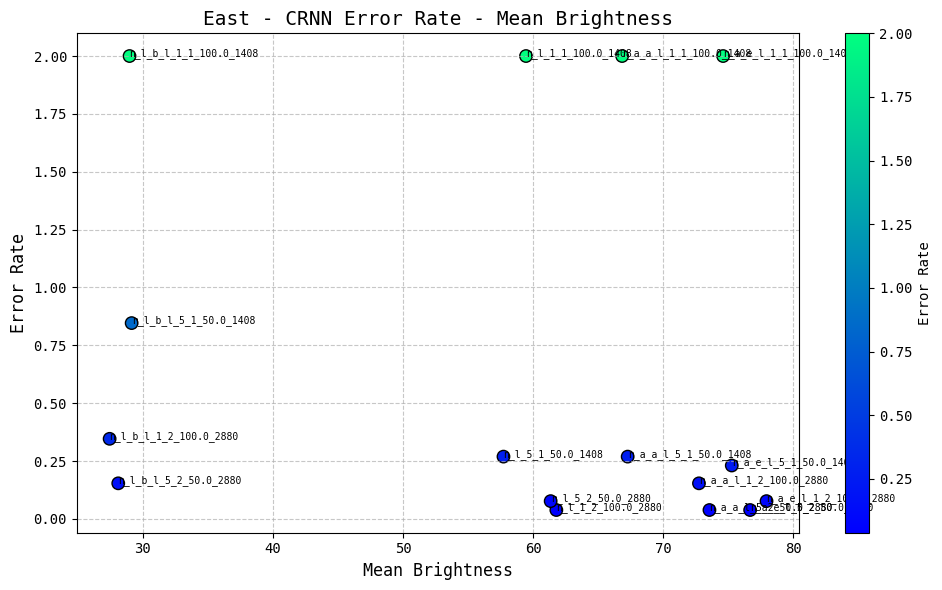

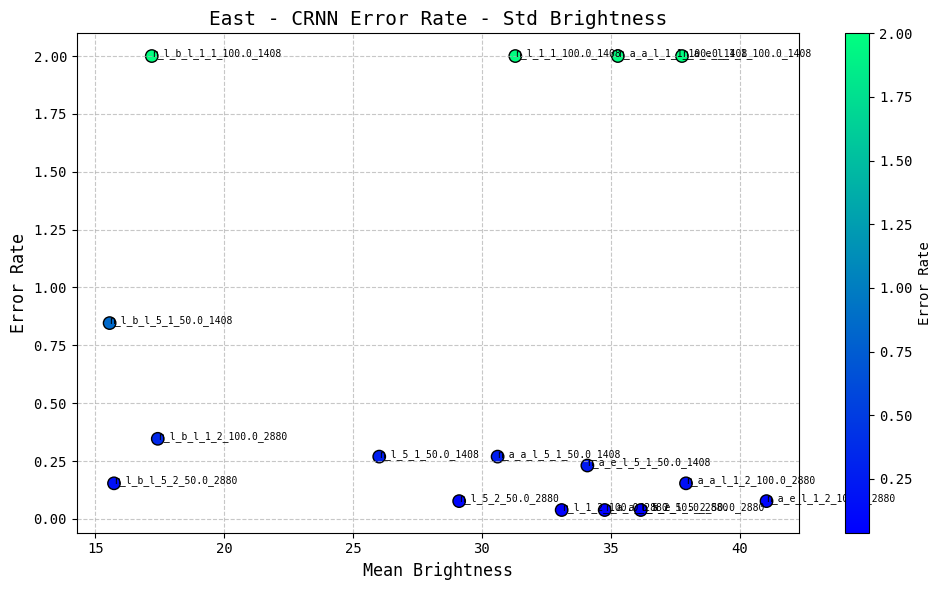

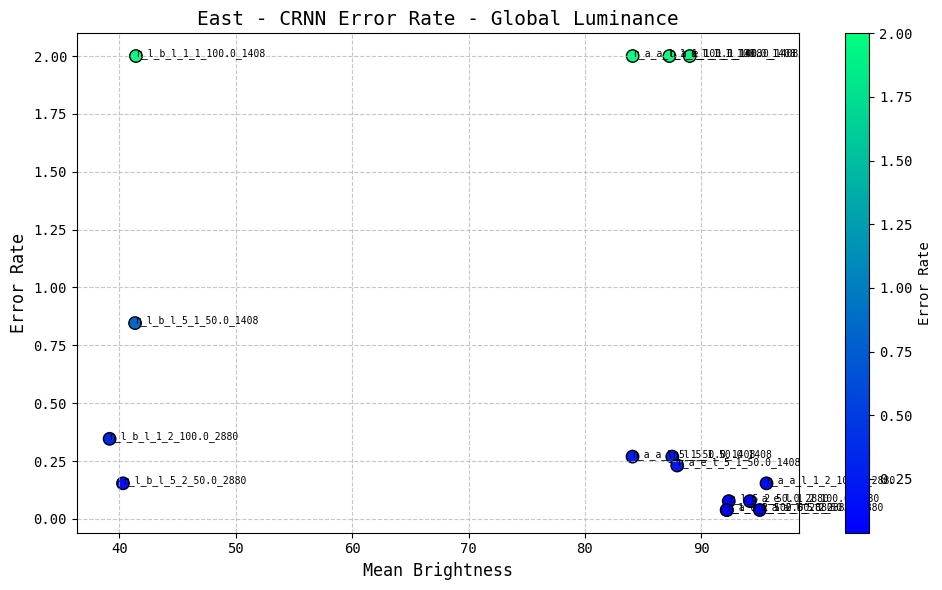

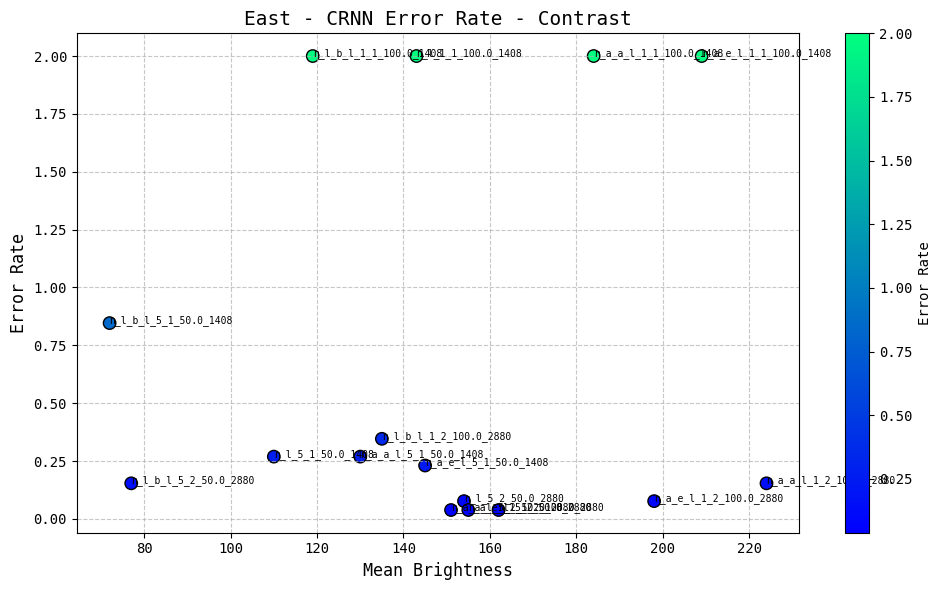

In [27]:
show_plot_for_lighting_type( east_with_crnn_error_rates, 0, "Mean Brightness",  "East - CRNN" )
show_plot_for_lighting_type( east_with_crnn_error_rates, 1, "Std Brightness" ,  "East - CRNN" )
show_plot_for_lighting_type( east_with_crnn_error_rates, 2, "Global Luminance", "East - CRNN" )
show_plot_for_lighting_type( east_with_crnn_error_rates, 3, "Contrast", "East - CRNN" )

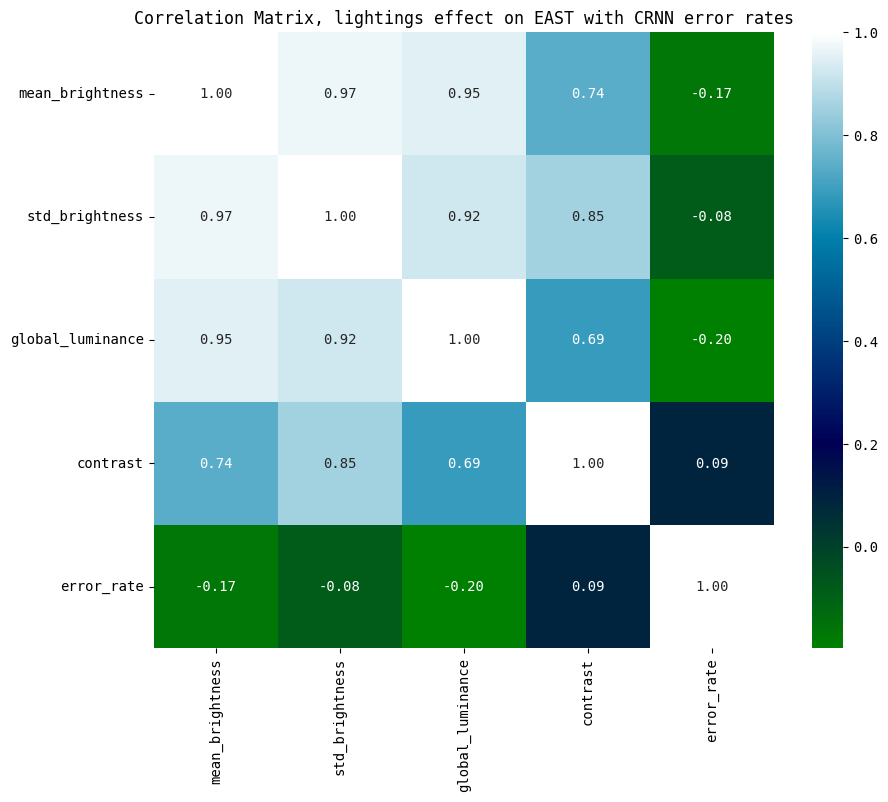

In [28]:
create_correlation_matrix_for_lighting_results( image_lighting_results, east_with_crnn_error_rates, "EAST with CRNN" )

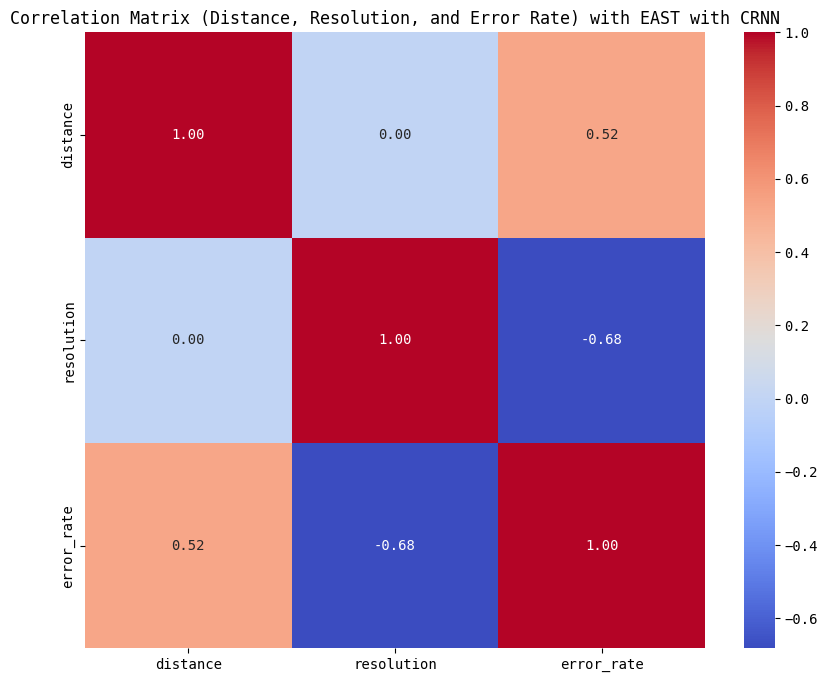

In [29]:
create_correlation_matrix_for_distance_and_resolution_results( east_with_crnn_error_rates, "EAST with CRNN" )

### Exploring lighting, distance and image resolution's effects on over all error rate using -> EAST + PyTesseract




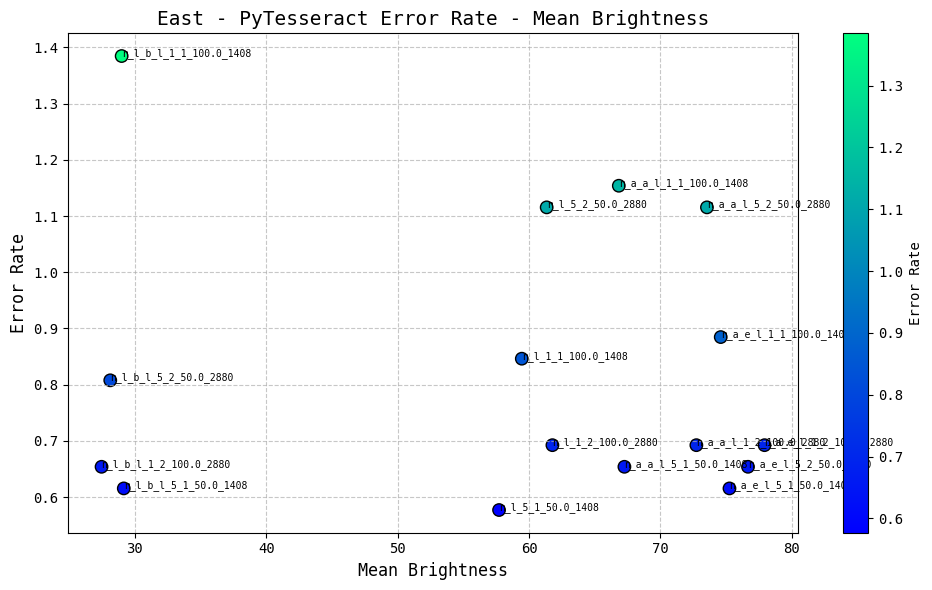

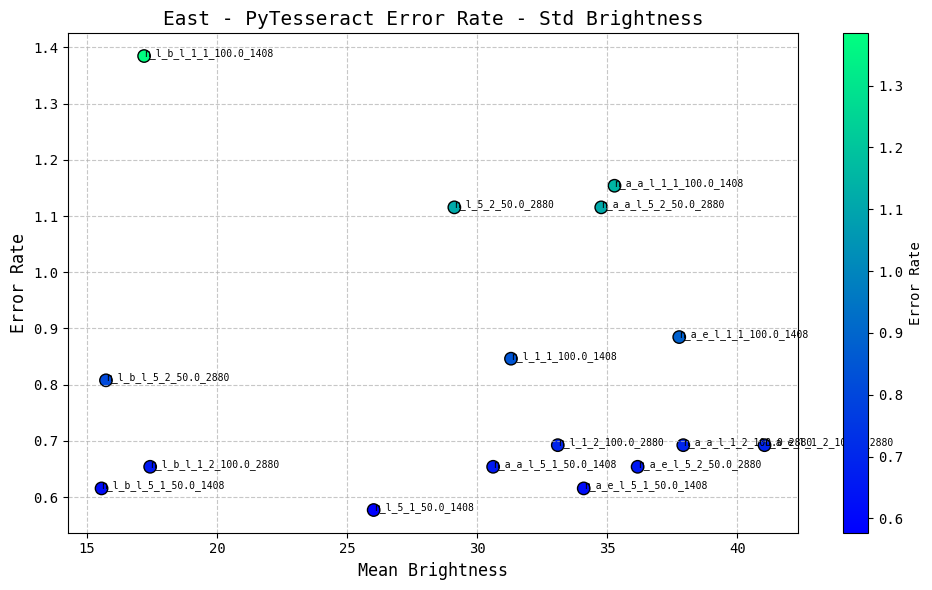

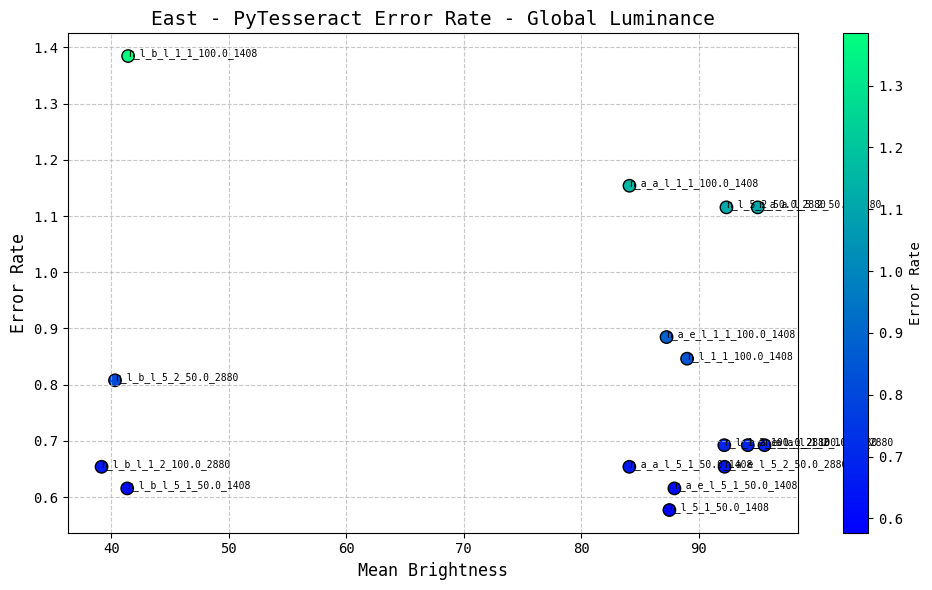

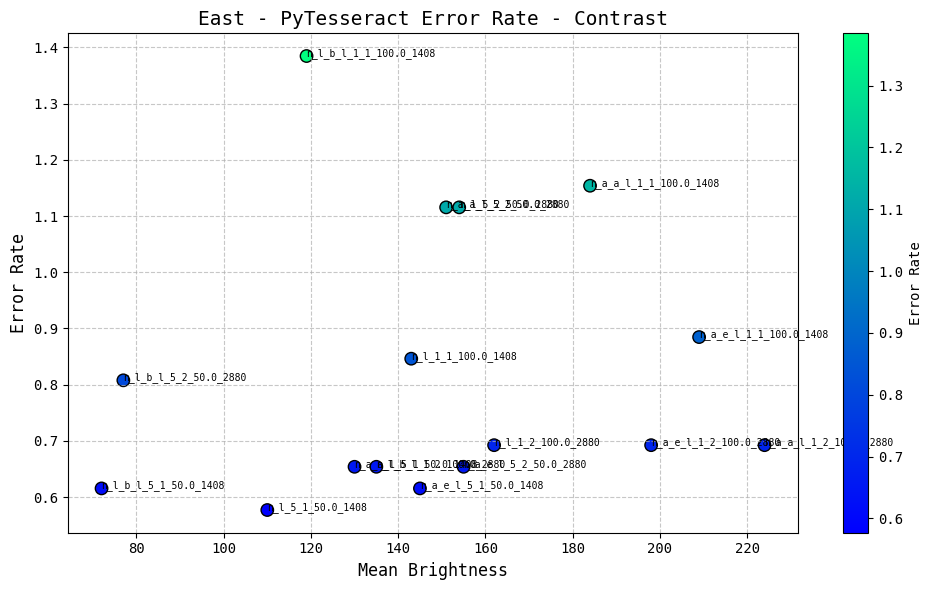

In [30]:
show_plot_for_lighting_type( east_with_pyTesseract_error_rates, 0, "Mean Brightness",  "East - PyTesseract" )
show_plot_for_lighting_type( east_with_pyTesseract_error_rates, 1, "Std Brightness" ,  "East - PyTesseract" )
show_plot_for_lighting_type( east_with_pyTesseract_error_rates, 2, "Global Luminance", "East - PyTesseract" )
show_plot_for_lighting_type( east_with_pyTesseract_error_rates, 3, "Contrast", "East - PyTesseract" )

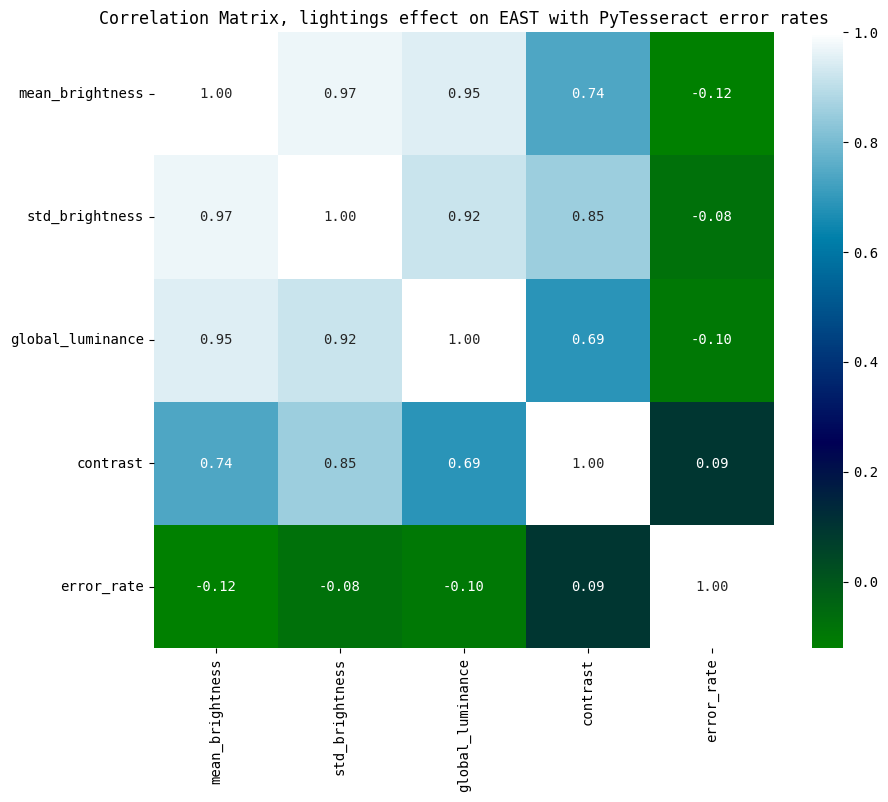

In [31]:
create_correlation_matrix_for_lighting_results( image_lighting_results, east_with_pyTesseract_error_rates, "EAST with PyTesseract" )

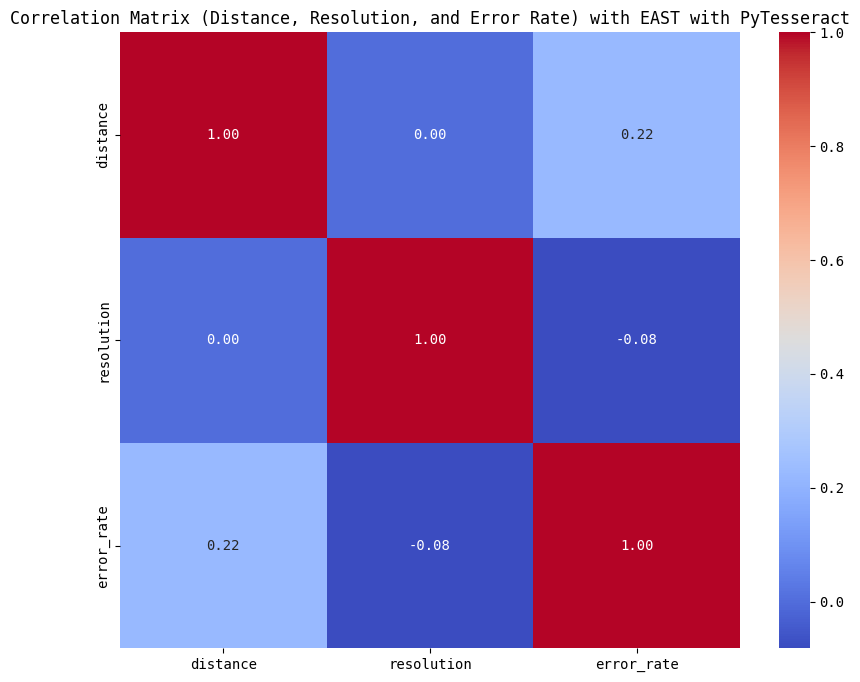

In [32]:
create_correlation_matrix_for_distance_and_resolution_results( east_with_pyTesseract_error_rates, "EAST with PyTesseract" )

## Image pre-processing specificially for CRNN

In [33]:
def image_pre_processing_for_CRNN( image ):
    #only pre-process if image lighting is below average
    if calculate_global_luminance(image) < average_lighting['global_luminance']:
      print("pre_processing_image")
      gamma = 0.8
      inv_gamma = 1.0 / gamma
      table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype(np.uint8)
      image = cv2.LUT(image, table)
      print(f"the brightness level is now: {calculate_global_luminance(image)}")
      return image
    else:
      print("image_not_pre_processed")
      return image

In [34]:
error_rates_pre_processed_crnn, recognized_text_pre_processed_crrn = get_image_dic_error_rate_for_algorithm(
    ground_truth_text,
    apply_east_with_recognition_algorithm,
    images,
    format_found_text,
    apply_crnn_to_text_box,
    None,
    image_pre_processing_for_CRNN
)


Output hidden; open in https://colab.research.google.com to view.

In [35]:
error_rates_pre_processed_crnn, recognized_text_pre_processed_crrn = get_image_dic_error_rate_for_algorithm(
    ground_truth_text,
    apply_east_with_recognition_algorithm,
    images,
    format_found_text,
    apply_crnn_to_text_box,
    image_pre_processing_for_CRNN,
    None
)

Output hidden; open in https://colab.research.google.com to view.

In [36]:
print( f"The average error rate for EAST with CRNN is: {calculate_average_error_rate(error_rates_pre_processed_crnn)}")

The average error rate for EAST with CRNN is: 0.673076923076923


depite incrasing lighting levels fpr darker images algorithms performance worsens